In [351]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
from PIL import Image
import math
import lightgbm as lgb
from pylab import rcParams


## Дополнительные функции

In [386]:
def area(box):
    return (box[2] - box[0]) * (box[3] - box[1])


def intersection_over_union(boxes):
    assert(len(boxes) == 8)
    boxA = boxes[:4].values
    boxB = boxes[4:].values
    
    boxAArea = area(boxA)
    boxBArea = area(boxB)
    
    if (boxAArea == 0 or boxBArea == 0):
        return 0
        
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


def plotItemRects(item_id, c = 'r'):
    item_data = data[data['itemId'] == item_id]
    #gt_item = answers[answers['itemId'] == item_id]
    rcParams['figure.figsize'] = 20, 10
    currentAxis = plt.gca()
    for i in range(item_data.shape[0]):
        first_point = (item_data.iloc[i]['Xmin'], item_data.iloc[i]['Ymin'])
        width = abs(int(item_data.iloc[i]['Xmax'] - item_data.iloc[i]['Xmin']))
        height = abs(int(item_data.iloc[i]['Ymax'] - item_data.iloc[i]['Ymin']))
        if c == 'auto':
            color = np.random.rand(1,3)[0]
        else:
            color = 'r'
        rect = patches.Rectangle(first_point, width, height, fill='None', facecolor='none',\
                                 linewidth=2, edgecolor=color)
        
        currentAxis.add_patch(rect)
    lab = [f'human {n}' for n in item_data['userId']]
    currentAxis.legend(lab)
    gt_width = abs(int(item_data['Xmax_true'].iloc[0] - item_data['Xmin_true'].iloc[0]))
    gt_height = abs(int(item_data['Ymax_true'].iloc[0] - item_data['Ymin_true'].iloc[0]))
    gt_rect = patches.Rectangle((int(item_data['Xmin_true'].iloc[0]), int(item_data['Ymin_true'].iloc[0])),\
                                gt_width, gt_height, fill='None', facecolor='none',linestyle='--',\
                                linewidth=3, edgecolor='g')
    currentAxis.add_patch(gt_rect)
    plt.autoscale()
    
    
def plotUserRects(user_id, c = 'r'):
    item_data = data[data['userId'] == user_id]
    #gt_item = answers[answers['itemId'] == item_id]
    
    rcParams['figure.figsize'] = 20, 10
    currentAxis = plt.gca()
    for i in range(item_data.shape[0]):
        first_point = (item_data.iloc[i]['Xmin'], item_data.iloc[i]['Ymin'])
        width = abs(int(item_data.iloc[i]['Xmax'] - item_data.iloc[i]['Xmin']))
        height = abs(int(item_data.iloc[i]['Ymax'] - item_data.iloc[i]['Ymin']))
        if c == 'auto':
            color = np.random.rand(1,3)[0]
        else:
            color = 'r'
        rect = patches.Rectangle(first_point, width, height, fill='None', facecolor='none',\
                                 linewidth=2, edgecolor=color)
        
        currentAxis.add_patch(rect)
    lab = [f'item {n}' for n in item_data['itemId']]
    currentAxis.legend(lab)
    plt.autoscale()   
    
    
def plotUserLoss(user_num):
    rcParams['figure.figsize'] = 20, 10
    user_list = data['userId'].unique()[:user_num]
    for user_id in user_list:
        user_data = data[data['userId'] == user_id]
        plt.scatter(user_data['userId'], user_data['iou'])
        
def intersection_of_items(areas):
    boxPrimary = areas.iloc[0].values
    for i in np.arange(1,areas.shape[0]):
        boxSecondary = areas.iloc[i].values
        xA = max(boxPrimary[0], boxSecondary[0])
        yA = max(boxPrimary[1], boxSecondary[1])
        xB = min(boxPrimary[2], boxSecondary[2])
        yB = min(boxPrimary[3], boxSecondary[3])
        boxPrimary = np.array([xA,yA,xB,yB])               
                       
    return area(boxPrimary)

In [412]:
 intersection_of_items(data[data['itemId']==i][['Xmin','Ymin','Xmax','Ymax']])

1484

In [410]:
data[data['itemId']==2776][['Xmin','Ymin','Xmax','Ymax', 'S']]

,Xmin,Ymin,Xmax,Ymax,S
2854,108,193,651,572,205797
2855,11,148,661,572,275600
2856,182,221,657,571,166250


## Чтение данных

In [11]:
votes = pd.read_csv("train_data.csv")
answers = pd.read_csv("train_answers.csv")
test_data = pd.read_csv("test_data.csv")

In [328]:
votes.head()

,userId,itemId,Xmin,Ymin,Xmax,Ymax
0,1164,6132,62,656,276,803
1,1399,6132,184,662,235,740
2,1694,6132,63,648,272,830
3,916,6132,111,637,253,831
4,1621,6132,60,651,242,819


In [329]:
answers.head()

,itemId,Xmin_true,Ymin_true,Xmax_true,Ymax_true
0,5,198,827,649,1340
1,10,26,605,433,847
2,13,233,698,622,920
3,30,61,368,329,530
4,32,30,536,328,813


In [330]:
test_data.head()

,userId,itemId,Xmin,Ymin,Xmax,Ymax
0,1581,34804,86,640,242,743
1,1351,34804,85,655,273,766
2,161,34804,85,648,268,748
3,313,5704,32,618,647,1268
4,1097,5704,25,620,602,1242


## Работа с данными, генерация фич

In [331]:
data = votes.merge(answers, on='itemId')

In [417]:
data["iou"] = data[['Xmin','Ymin', 'Xmax', 'Ymax', 'Xmin_true',\
      'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)
data['user_score'] = 0

In [418]:
data[data['itemId'] == 6132].sort_values('iou', ascending=False)

,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_true,Ymin_true,Xmax_true,Ymax_true,iou,S,S_true,Xcenter,Ycenter,Xcenter_true,Ycenter_true,bias_vector_abs,user_score
4,1621,6132,60,651,242,819,47,650,213,812,0.750206,30576,26892,151.0,735.0,130.0,731.0,21.377558,0
5,1092,6132,39,649,249,825,47,650,213,812,0.727597,36960,26892,144.0,737.0,130.0,731.0,15.231546,0
0,1164,6132,62,656,276,803,47,650,213,812,0.613974,31458,26892,169.0,729.5,130.0,731.0,39.028835,0
2,1694,6132,63,648,272,830,47,650,213,812,0.598080,38038,26892,167.5,739.0,130.0,731.0,38.343839,0
3,916,6132,111,637,253,831,47,650,213,812,0.435805,27548,26892,182.0,734.0,130.0,731.0,52.086467,0
1,1399,6132,184,662,235,740,47,650,213,812,0.079069,3978,26892,209.5,701.0,130.0,731.0,84.972054,0


In [414]:
data.sort_values('iou', ascending=False)

,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_true,Ymin_true,Xmax_true,Ymax_true,iou,S,S_true,Xcenter,Ycenter,Xcenter_true,Ycenter_true,bias_vector_abs
0,1164,6132,62,656,276,803,47,650,213,812,0.613974,31458,26892,169.0,729.5,130.0,731.0,39.028835
1,1399,6132,184,662,235,740,47,650,213,812,0.079069,3978,26892,209.5,701.0,130.0,731.0,84.972054
2,1694,6132,63,648,272,830,47,650,213,812,0.598080,38038,26892,167.5,739.0,130.0,731.0,38.343839
3,916,6132,111,637,253,831,47,650,213,812,0.435805,27548,26892,182.0,734.0,130.0,731.0,52.086467
4,1621,6132,60,651,242,819,47,650,213,812,0.750206,30576,26892,151.0,735.0,130.0,731.0,21.377558


In [419]:
item_list = data['itemId'].unique()
for item_id in item_list:
    temp_data = data[data['itemId'] == item_id].sort_values('iou', ascending=False)
    for i in np.arange(temp_data.shape[0]):
        temp_data.iloc[i]['user_score'] += 5-i

/home/vladislav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [464]:
data.describe()

,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_true,Ymin_true,Xmax_true,Ymax_true,iou,S,S_true,Xcenter,Ycenter,Xcenter_true,Ycenter_true,bias_vector_abs,user_score
count,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.0
mean,887.452314,18453.165449,118.653738,655.571107,427.583286,922.288364,83.571857,634.282556,460.840922,949.629380,0.452874,119798.725126,165326.825557,273.118512,788.929736,272.206389,791.955968,69.890009,0.0
std,503.188648,10315.663750,104.185583,259.420920,249.922350,273.005802,75.005770,258.224909,263.547221,287.810484,0.194594,141429.415591,179205.312565,154.972908,248.358733,148.780576,251.788882,65.226895,0.0
min,0.000000,5.000000,-4.000000,40.000000,14.000000,188.000000,-1.000000,21.000000,37.000000,389.000000,0.000000,0.000000,0.000000,13.500000,169.500000,32.000000,288.000000,0.000000,0.0
25%,453.000000,9407.000000,49.000000,472.000000,217.000000,711.000000,32.000000,455.000000,243.000000,726.000000,0.336987,14043.000000,25375.000000,145.500000,592.000000,146.500000,584.000000,22.461077,0.0
50%,903.000000,19187.000000,83.000000,639.000000,398.000000,901.000000,54.000000,627.000000,439.000000,932.000000,0.475689,63206.000000,100868.000000,256.500000,776.500000,261.500000,778.500000,51.546096,0.0
75%,1322.000000,27121.000000,152.000000,833.000000,611.000000,1111.000000,114.000000,815.000000,664.000000,1132.000000,0.582140,177560.000000,247104.000000,386.500000,968.000000,381.000000,973.500000,97.275382,0.0
max,1753.000000,35962.000000,965.000000,1532.000000,1051.000000,1903.000000,434.000000,1640.000000,1061.000000,1949.000000,1.000000,967000.000000,977130.000000,967.000000,1709.500000,687.000000,1755.000000,629.931941,0.0


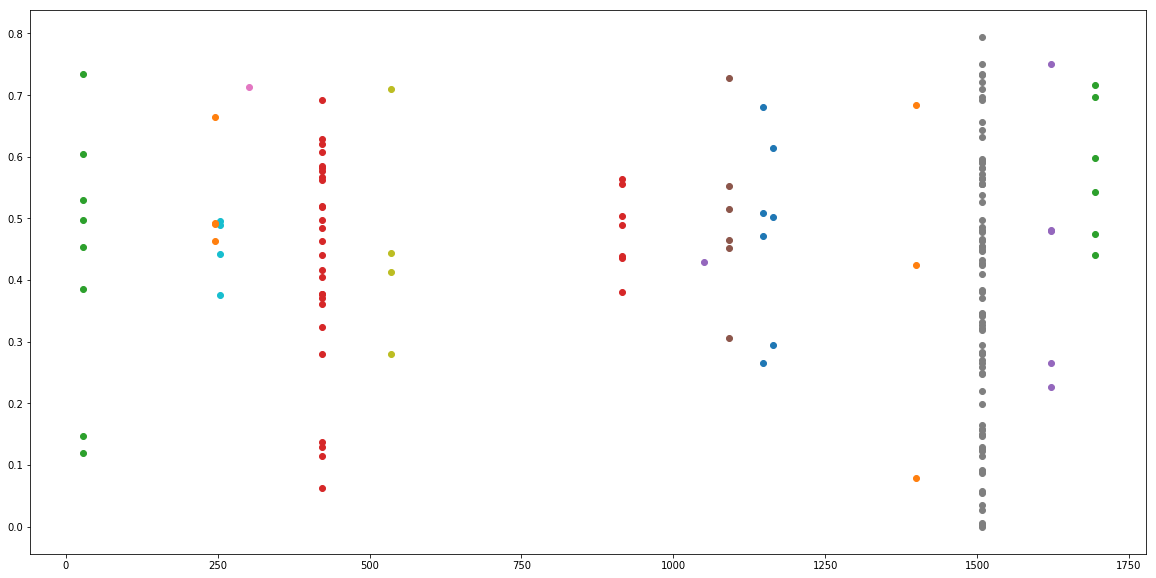

In [347]:
plotUserLoss(15)

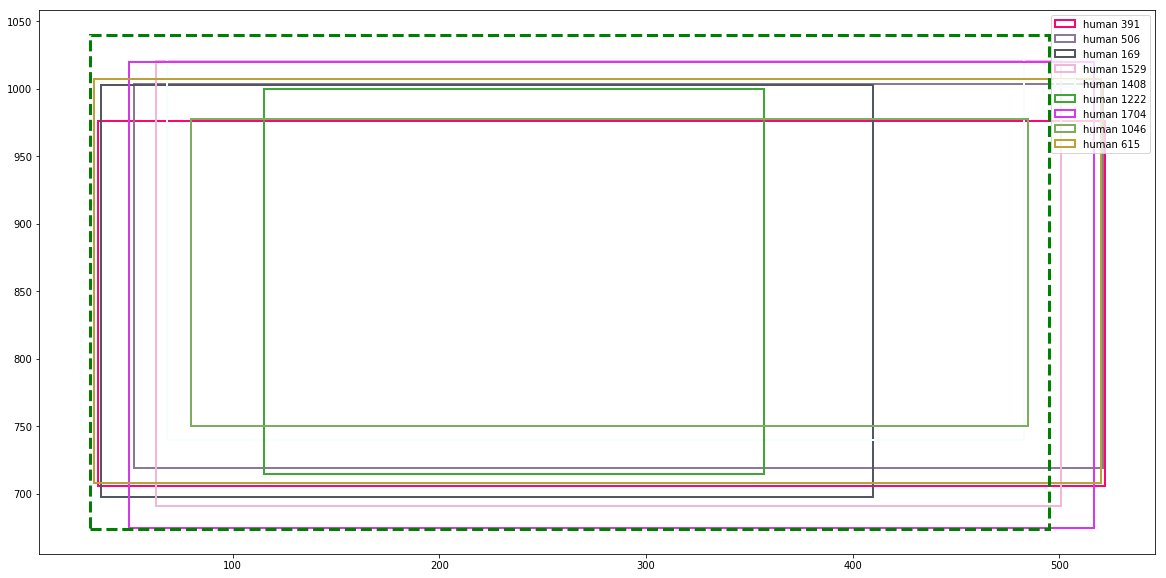

In [473]:
plotItemRects(34170, c='auto')

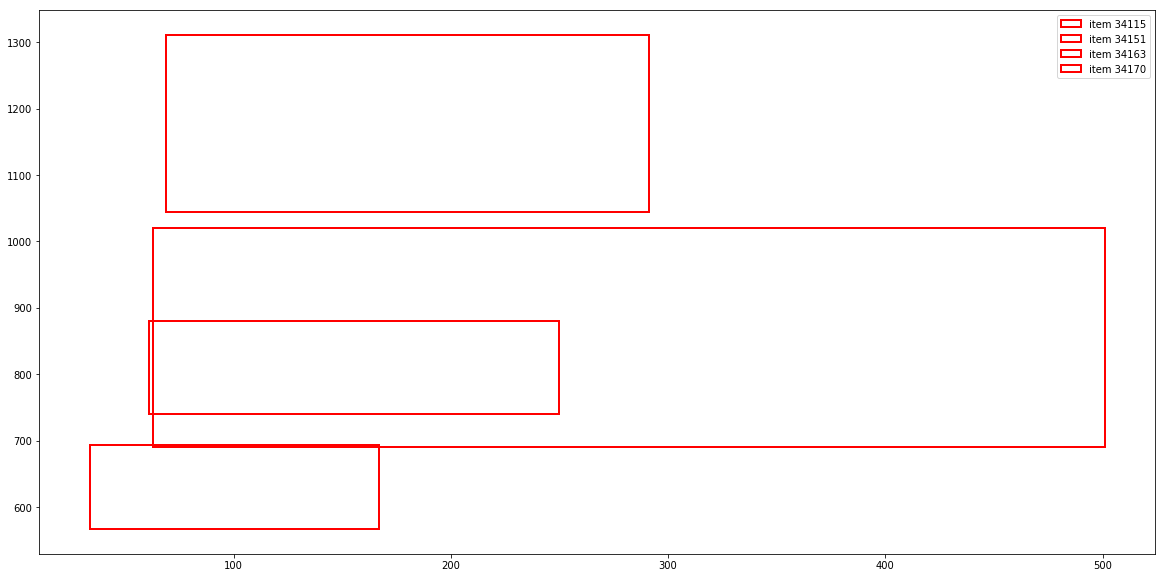

In [469]:
plotUserRects(1529, c = 'r')

In [239]:
data['itemId'].unique()[:5]

array([ 6132, 31297, 18168,  8398,  8774])

In [255]:
data[data['userId']==1408]

,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_true,Ymin_true,Xmax_true,Ymax_true,iou
196,1408,35719,198,646,536,915,28,573,707,1022,0.298231
680,1408,35123,107,1051,240,1180,138,1077,241,1213,0.508543
942,1408,35102,247,983,794,1338,247,1066,703,1402,0.555278
2800,1408,35962,85,514,376,882,17,469,391,1037,0.504105
4616,1408,34170,68,740,483,1022,31,674,495,1040,0.689125
4869,1408,22483,37,768,40,770,37,768,40,770,1.000000
5165,1408,22052,164,663,683,1257,160,721,891,1183,0.590252


In [368]:
data['S'] = abs((data['Xmax'] - data['Xmin']) * (data['Ymax'] - data['Ymin']))
data['S_true'] = abs((data['Xmax_true'] - data['Xmin_true']) * (data['Ymax_true'] - data['Ymin_true']))
data['Xcenter'] = (data['Xmax'] + data['Xmin']) / 2
data['Ycenter'] = (data['Ymax'] + data['Ymin']) / 2
data['Xcenter_true'] = (data['Xmax_true'] + data['Xmin_true']) / 2
data['Ycenter_true'] = (data['Ymax_true'] + data['Ymin_true']) / 2
data['bias_vector_abs'] = np.sqrt((data['Xcenter']-data['Xcenter_true']) ** 2 + \
                                  (data['Ycenter']-data['Ycenter_true']) ** 2)

test_data['S'] = abs((test_data['Xmax'] - test_data['Xmin']) * (test_data['Ymax'] - test_data['Ymin']))

In [423]:
td = test_data.merge(data[['userId', 'iou']], on='userId')
new_td = td.groupby('itemId').max()

In [446]:
new_td

,userId,Xmin,Ymin,Xmax,Ymax,S,iou
itemId,,,,,,,
18,1723,144,774,764,1132,308760,0.901075
19,1723,34,564,119,729,14280,0.901075
33,1565,75,413,414,652,106896,0.879371
62,1573,125,1054,639,1262,254040,0.901075
114,1383,80,580,216,780,31200,0.813968
146,1725,120,757,643,1118,211932,0.813968
156,533,92,802,160,887,6622,0.750379
163,1725,56,327,213,465,27122,0.793429
164,1508,18,151,401,681,212395,0.813968


## Обучаем модели

In [375]:
model = lgb.LGBMRegressor(boosting_type='gbdt',
                          num_leaves=7,
                          max_depth=-1,
                          learning_rate=0.1,
                          n_estimators=100,
                          subsample_for_bin=200000,
                          objective=None,
                          class_weight=None,
                          min_split_gain=0.0,
                          min_child_weight=0.001,
                          min_child_samples=20,
                          subsample=1.0,
                          subsample_freq=0,
                          colsample_bytree=1.0,
                          reg_alpha=0.0,
                          reg_lambda=0.0,
                          random_state=42,
                          n_jobs=-1)
params = {'num_leaves': np.arange(2, 30, 5),
         'max_depth': np.arange(1, 30, 3)}
est = GridSearchCV(model,param_grid=params, n_jobs=-1)

In [354]:
data.head()

,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_true,Ymin_true,Xmax_true,Ymax_true,iou,S,S_true,Xcenter,Ycenter,Xcenter_true,Ycenter_true,bias_vector_abs
0,1164,6132,62,656,276,803,47,650,213,812,0.613974,31458,26892,169.0,729.5,130.0,731.0,39.028835
1,1399,6132,184,662,235,740,47,650,213,812,0.079069,3978,26892,209.5,701.0,130.0,731.0,84.972054
2,1694,6132,63,648,272,830,47,650,213,812,0.598080,38038,26892,167.5,739.0,130.0,731.0,38.343839
3,916,6132,111,637,253,831,47,650,213,812,0.435805,27548,26892,182.0,734.0,130.0,731.0,52.086467
4,1621,6132,60,651,242,819,47,650,213,812,0.750206,30576,26892,151.0,735.0,130.0,731.0,21.377558


In [374]:
tr_data = data.groupby('itemId', as_index=False, sort=False).mean()

In [372]:
est.fit(X=tr_data[['Xmin','iou', 'S',]],y=tr_data[['Xmin_true']])

/home/vladislav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=17, objective=None,
       random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'num_leaves': array([ 2,  7, 12, 17, 22, 27]), 'max_depth': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [373]:
est.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=4,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=7, objective=None,
       random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [376]:
model.fit(X=tr_data[['Xmin','iou', 'S']], y=tr_data[['Xmin_true']])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=7, objective=None,
       random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [377]:
model.feature_importances_

array([202, 199, 199])

In [378]:
cross_val_score(model,X=tr_data[['Xmin','iou', 'S']], y=tr_data[['Xmin_true']], cv=5)

array([0.09559667, 0.1444349 , 0.20909411, 0.08123304, 0.13399713])

In [367]:
model.predict(td[['Xmin', 'iou', 'S']])

ValueError: Number of features of the model must match the input. Model n_features_ is 9 and input n_features is 1 

## Сабмит результатов

In [447]:
sample_submit = pd.read_csv('sample_submit_zero.csv',names=['userId','Xmin','Ymin','Xmax', 'Ymax'], header=None)

In [455]:
subm = new_td.reset_index()[['itemId','Xmin','Ymin','Xmax','Ymax']]

In [456]:
subm.to_csv('submit_2_28062019_max_iou.csv',header=False,index=False)

In [423]:
data["iou"] = data[['Xmin','Ymin', 'Xmax', 'Ymax', 'Xmin_true',\
      'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)

In [425]:
data["iou"].mean()

0.5058725791429202